In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import numpy as np # linear algebra
import pandas as pd 

In [3]:
import os
path = '../input'
print(os.listdir(path))

['train.csv', 'sample_submission.csv', 'test.csv']


In [4]:

class CustomImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1)
        return Image(pil2tensor(img, dtype=np.float32))
    
    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList': 
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        
        return res


In [5]:
test = CustomImageList.from_csv_custom(path=path, csv_name='test.csv', imgIdx=0)

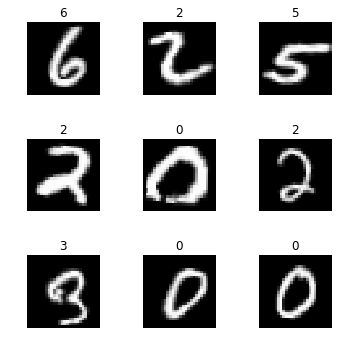

In [6]:
    tfms = get_transforms(do_flip=False)
    data = (CustomImageList.from_csv_custom(path=path, csv_name='train.csv', imgIdx=1)
                .split_by_rand_pct(.2)
                .label_from_df(cols='label')
                .add_test(test, label=0)
                 #src.transform(tfms, size=256)
                .transform(tfms,size=28)
                .databunch(bs=128, num_workers=0)
                .normalize(imagenet_stats))
    data.show_batch(rows=3, figsize=(5,5))

In [7]:
#learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/kaggle/working/models')
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir='/kaggle/working/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 108387978.15it/s]


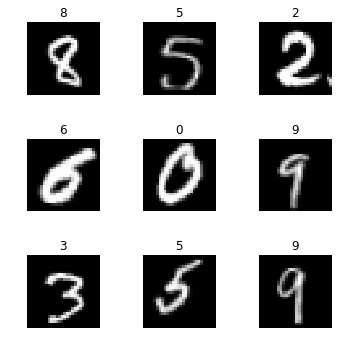

In [8]:
data.show_batch(rows=3, figsize=(5,5))


In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.876699,0.724711,0.769762,01:13
1,0.415078,0.320633,0.895833,01:06
2,0.282087,0.224893,0.928095,01:07
3,0.246934,0.208649,0.933810,01:07


# Training with different sizes

In [10]:
classes = [10,14,18,22,25,28]

In [11]:
for c in classes:
    tfms = get_transforms(do_flip=False)
    data = (CustomImageList.from_csv_custom(path=path, csv_name='train.csv', imgIdx=1)
                .split_by_rand_pct(.2)
                .label_from_df(cols='label')
                .add_test(test, label=0)
                 #src.transform(tfms, size=256)
                .transform(tfms,size=c)
                .databunch(bs=128, num_workers=0)
                .normalize(imagenet_stats))
    data.show_batch(rows=3, figsize=(5,5))
    learn.data = data
    c
    learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,1.574113,1.123808,0.650595,01:13
1,1.004496,0.793525,0.782024,01:10
2,0.743272,0.490611,0.853691,01:10
3,0.592183,0.352648,0.888571,01:10
4,0.480059,0.289397,0.907024,01:09
5,0.443536,0.283007,0.913452,01:09
6,0.416629,0.278231,0.917619,01:10
7,0.405854,0.257231,0.919286,01:10


epoch,train_loss,valid_loss,accuracy,time
0,0.655297,0.421268,0.862738,01:06
1,0.441188,0.262831,0.913452,01:05
2,0.321326,0.189567,0.939048,01:05
3,0.253701,0.157624,0.950595,01:06
4,0.207959,0.128787,0.957738,01:06
5,0.184001,0.118421,0.963690,01:05


In [12]:
#learn.data = data

In [13]:
learn.save('stage-1-resnet50')

In [14]:
learn.load('stage-1-resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: CustomImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,0,1,4,0
Path: ../input;

Valid: LabelList (8400 items)
x: CustomImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
9,1,4,3,8
Path: ../input;

Test: LabelList (28000 items)
x: CustomImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: ../input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1

In [15]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


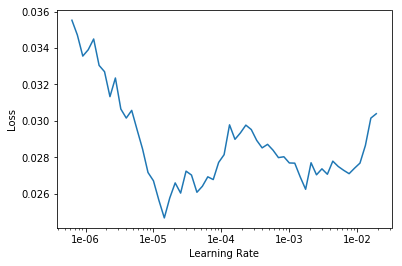

In [16]:
learn.recorder.plot()

In [17]:
learn.unfreeze()
learn.fit_one_cycle(12, max_lr=slice(1e-6,5e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.062275,0.050411,0.985714,01:04
1,0.141089,0.093742,0.982976,01:03
2,0.180244,0.125021,0.979643,01:03
3,0.162387,0.100296,0.979405,01:03
4,0.143508,0.141921,0.978571,01:06
5,0.134712,0.074534,0.989524,01:09
6,0.090848,0.470535,0.990238,01:11
7,0.061570,4.784112,0.988214,01:12
8,0.043205,10.470746,0.990952,01:11
9,0.024520,1.945855,0.992619,01:08


In [18]:
learn.save('stage-1-resnet50')

In [19]:
learn.load('stage-1-resnet50')
learn.validate()

[0.66318196, tensor(0.9935)]

In [20]:
learn.unfreeze()
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


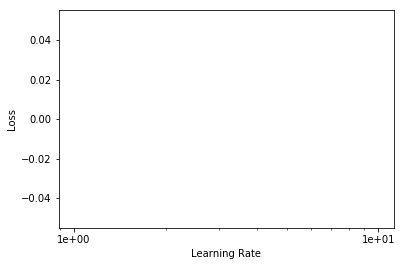

In [21]:
learn.recorder.plot()

In [22]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.014374,1.591186,0.993571,01:12
1,0.014613,1.888596,0.993452,01:13
2,0.017593,0.897444,0.994286,01:12
3,0.012330,2.292769,0.993929,01:10


In [23]:
learn.save('stage-1-resnet50')

In [24]:
learn.load('stage-1-resnet50')
learn.validate()

[2.2927694, tensor(0.9939)]

In [25]:
#learn.lr_find()

In [26]:
#learn.recorder.plot()

In [27]:
#learn.lr_find()

In [28]:
#learn.recorder.plot()

In [29]:
#learn.unfreeze()
#learn.fit_one_cycle(5,1e-4)

In [30]:
#learn.save('stage-1-resnet50')

In [31]:
#learn.load('stage-1-resnet50')
#learn.validate()

In [32]:
#learn.lr_find()

In [33]:
#learn.recorder.plot()

In [34]:
#learn.unfreeze()
#learn.fit_one_cycle(8, max_lr=slice(1e-5, 2.5e-4))

In [35]:
#learn.save('stage-1-resnet50')
#learn.load('stage-1-resnet50')
#learn.validate()

In [36]:
# get the predictions
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)